# **Non-Stationary Federated Learning**



*   Deep Learning Framework: **PyTorch**
*   Dataset: **Synthetic**
*   Workers: **4**
*   Data Distribution: **IID on workers**





## Importing libraries and setting parameters for training


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F


import os
import numpy as np
import math

from Stationary.core import *
from Stationary.utils import *

from sklearn import linear_model, datasets
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [2]:
num_workers = 4
num_rounds = 10

## Synthetic Dataset

We create a synthetic dataset, reproducing a linear correlation between inputs and outputs, with the addition of a noise.

Train set is divided into multiple slots, in order to reproduce the "online" approach: For each round, each worker has a different set for training phase.


In [3]:
# Linear Regression Coefficients
m = 1.4
c = 10

dataset_X = np.linspace(0, 10, 1000)
np.random.shuffle(dataset_X)

dataset_y =  dataset_X * m + c +  np.random.randn(dataset_X.size) * math.sqrt(3)

dataset_X = dataset_X.reshape(-1,1)
dataset_y = dataset_y.reshape(-1,1)

In [4]:
train_percentage = 0.9


train_X, test_X = np.split(dataset_X, 
            [int(train_percentage * len(dataset_X))
            ])

train_y, test_y = np.split(dataset_y, 
            [int(train_percentage * len(dataset_y))
            ])

In [5]:
train_list_X = splitDataset(train_X, num_workers, num_rounds)
train_list_y = splitDataset(train_y, num_workers, num_rounds)

In [6]:
worker_list = []
for i in range(0, num_workers):
    worker_list.append(Worker(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), model=linear_model.LinearRegression()))

In [7]:
server = Server(coef = np.zeros(shape=dataset_X[0].size), intercept = np.zeros(shape=1), workers = worker_list, num_features = dataset_X[0].size)

In [8]:
error = []
score = []

for i in range(0, num_rounds):
    
    for j in range(0, num_workers):
        worker_list[j].train(X = train_list_X[i*num_workers+j] , y = train_list_y[i*num_workers+j])

    server.aggregation() 
    server.return_to_workers()
    
    pred_server = server.evaluate(test_X)
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, pred_server))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, pred_server))
    error.append(mean_squared_error(test_y, pred_server))
    score.append(r2_score(test_y, pred_server))

------ROUND 1------
Mean squared error: 3.216
Coefficient of determinaton: 0.826 

------ROUND 2------
Mean squared error: 3.240
Coefficient of determinaton: 0.825 

------ROUND 3------
Mean squared error: 3.284
Coefficient of determinaton: 0.822 

------ROUND 4------
Mean squared error: 3.259
Coefficient of determinaton: 0.824 

------ROUND 5------
Mean squared error: 3.234
Coefficient of determinaton: 0.825 

------ROUND 6------
Mean squared error: 3.267
Coefficient of determinaton: 0.823 

------ROUND 7------
Mean squared error: 3.245
Coefficient of determinaton: 0.824 

------ROUND 8------
Mean squared error: 3.237
Coefficient of determinaton: 0.825 

------ROUND 9------
Mean squared error: 3.246
Coefficient of determinaton: 0.824 

------ROUND 10------
Mean squared error: 3.250
Coefficient of determinaton: 0.824 



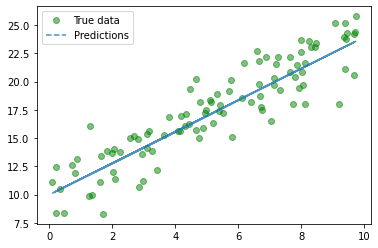

In [9]:
plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, pred_server, '--', label='Predictions', alpha=0.8)
plt.legend(loc='best')
plt.show()

# Federated Averaging

Implementation of FedAVG in PyTorch. 

First of all, the dataset is converted in tensors.
Then, a model, a loss function and an optimizer are instantiated for each worker.
Model parameters are averaged at each round.

In [10]:
from torch.autograd import Variable

for i in range(0, len(train_list_X)):
    train_list_X[i] = torch.from_numpy(train_list_X[i])

for i in range(0, len(train_list_y)):
    train_list_y[i] = torch.from_numpy(train_list_y[i])

## Model


In [11]:
class linearRegression(torch.nn.Module):
    
    def __init__(self, inputSize, outputSize):
        
        super(linearRegression, self).__init__()
        self.linear = torch.nn.Linear(inputSize, outputSize, bias=True)

        
    def forward(self, x):
        
        out = self.linear(x)
        return out


In [12]:
w = []

for i in range(0, num_workers):
    
    w.append(linearRegression(dataset_X[0].size, dataset_y[0].size))
    w[i] = w[i].float()

In [13]:
learning_rate = 1e-4

criterion = []
optimizers = []

for i in w:
    
    criterion.append(torch.nn.MSELoss()) 
    optimizers.append(torch.optim.SGD(i.parameters(), lr=learning_rate))

In [14]:
params = []


for i in w:
    params.append(list(i.parameters()))

In [15]:
local_epochs = 100

error = []
score = []

for model in w:
    
    model.train()

for i in range(num_rounds):

    for j in range(0, num_workers):

        for epoch in range(local_epochs):
            
            optimizers[j].zero_grad()
            loss = 0
            
            for x in range(len(train_list_X[i*num_workers+j])):
                inputs = (train_list_X[i*num_workers+j][x]).float()
                inputs = inputs.unsqueeze(0)
                labels = (train_list_y[i*num_workers+j][x]).float()
                labels = labels.unsqueeze(0)
                y_pred = w[j](inputs)
                loss += criterion[j](y_pred, labels)
            
            loss.backward()
            optimizers[j].step()
     
    
    new_params = list()

    for param_i in range(len(params[0])):

        spdz_params = list()

        for remote_index in range(len(w)):
            spdz_params.append(params[remote_index][param_i])
        
        spdz = torch.tensor([0.0]).float()

        for i in spdz_params:
            spdz = spdz + i
        
        new_param = (spdz) / len(w)
        new_params.append(new_param)
    
    with torch.no_grad():
        for model in params:
            for param in model:
                param *= 0
        
        for remote_index in range(len(w)):
            for param_index in range(len(params[remote_index])):
                params[remote_index][param_index].set_(new_params[param_index])
    
    
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()
    
    print('------ROUND {}------'.format(i+1))
    print('Mean squared error: %.3f' 
          % mean_squared_error(test_y, predicted))
    print('Coefficient of determinaton: %.3f \n'
          % r2_score(test_y, predicted))
    error.append(mean_squared_error(test_y, predicted))
    score.append(r2_score(test_y, predicted))
    

------ROUND tensor([2.4454], grad_fn=<AddBackward0>)------
Mean squared error: 19.430
Coefficient of determinaton: -0.051 

------ROUND tensor([5.6200], grad_fn=<AddBackward0>)------
Mean squared error: 9.787
Coefficient of determinaton: 0.470 

------ROUND tensor([7.7104], grad_fn=<AddBackward0>)------
Mean squared error: 5.681
Coefficient of determinaton: 0.693 

------ROUND tensor([8.7895], grad_fn=<AddBackward0>)------
Mean squared error: 4.573
Coefficient of determinaton: 0.753 

------ROUND tensor([9.4411], grad_fn=<AddBackward0>)------
Mean squared error: 3.842
Coefficient of determinaton: 0.792 

------ROUND tensor([9.9938], grad_fn=<AddBackward0>)------
Mean squared error: 4.114
Coefficient of determinaton: 0.777 

------ROUND tensor([10.5379], grad_fn=<AddBackward0>)------
Mean squared error: 3.290
Coefficient of determinaton: 0.822 

------ROUND tensor([10.6556], grad_fn=<AddBackward0>)------
Mean squared error: 3.247
Coefficient of determinaton: 0.824 

------ROUND tensor([

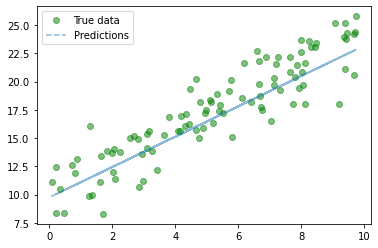

In [17]:
with torch.no_grad(): 
    predicted = w[0](Variable(torch.from_numpy(test_X).float())).data.numpy()

plt.clf()
plt.plot(test_X, test_y, 'go', label='True data', alpha=0.5)
plt.plot(test_X, predicted, '--', label='Predictions', alpha=0.5)
plt.legend(loc='best')
plt.show()

In [18]:
print(mean_squared_error(test_y, pred_server))
print(r2_score(test_y, pred_server))

3.249629860175362
0.824183970253846
